# File Setup

In [1]:
import os
print(os.listdir())
directory_path = ''

#from google.colab import drive
#import sys
#drive.mount('/content/drive')
#directory_path = '/content/drive/MyDrive/Quantum/'
#sys.path.append('/content/drive/MyDrive/Quantum')
# print(os.listdir(directory_path))

['dense_small.param', '.DS_Store', 'quantum_experiments', 'DiscreteVariationalParameterizationsDeepV2.py', 'Mutual_Information_Transformer.ipynb', '__pycache__', 'DiscreteVariationalParameterizationsDeepV3.py', 'README.md', 'Mutual_Information_Maximizing_Model.ipynb', 'temp.txt', '.ipynb_checkpoints', '.git', 'QuantumSimulatorDataset.py', 'GibbsSampling.py', 'Mutual_Information_VAETransformer.ipynb', '.idea']


In [118]:
!pip install torch
!pip install torchmetrics
!pip install qiskit-aer
!pip install qiskit
!pip install pylatexenc
!pip install tqdm
!pip install scikit-learn

In [119]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import ast
import torch.optim as optim
import torch.nn.functional as F
from torchmetrics.clustering import MutualInfoScore
from sklearn.metrics import mutual_info_score
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from QuantumSimulatorDataset import QuantumSimulationDatasetFast, generate_circuit_params
from sklearn.model_selection import train_test_split

# Utility Functions

In [120]:
def calc_binary_accuracy(predictions, targets):
    correct = (predictions == targets).float().sum()
    accuracy = correct / targets.numel()
    return accuracy.item()

def entropy(X):
    # Flatten the tensor to 1D
    X_flat = X.view(-1)
    
    # Count the occurrences of each unique value
    unique_vals, counts = X_flat.unique(return_counts=True)
    probabilities = counts.float() / counts.sum()
    entropy = -torch.sum(probabilities * torch.log(probabilities))
        
    return entropy.item()

class MutualInformationLoss(nn.Module):
    def forward(self, input, target):
        X_flat = input.view(-1)
        Y_flat = target.view(-1)
        
        # Compute mutual information
        mi = mutual_info_score(X_flat, Y_flat)
    
        # Convert mutual information to a tensor and return the negative as loss
        mi_tensor = torch.tensor(mi, dtype=torch.float32, requires_grad=True).to(input.device)
        return -mi_tensor
    
def lighten(color, amount=0.3):
    c = color
    c = mcolors.to_rgb(c)
    white = np.array([1.0, 1.0, 1.0])
    new_color = (1.0 - amount) * np.array(c) + amount * white
    return tuple(new_color)

# VAETransformer Definition

In [121]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc2_mu(h)
        logvar = self.fc2_logvar(h)
        return mu, logvar

class LatentTransformer(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super(LatentTransformer, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, z_init):
        temp = F.relu(self.fc1(z_init))
        temp = F.relu(self.fc2(temp))
        return F.relu(self.fc3(temp))

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, z_final):
        h = F.relu(self.fc1(z_final))
        return torch.sigmoid(self.fc2(h))

class VAETransformer(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim, num_ones, hidden_dim=128):
        super(VAETransformer, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim, hidden_dim)
        self.latent_transformer = LatentTransformer(latent_dim, hidden_dim)
        self.decoder = Decoder(latent_dim, output_dim, hidden_dim)
        self.num_ones = num_ones
        self.hidden_dim = hidden_dim
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x_init):
        mu, logvar = self.encoder(x_init)
        z_init = self.reparameterize(mu, logvar)
        z_final = self.latent_transformer(z_init)
        x_final = self.decoder(z_final)
        return x_final, mu, logvar

    def conservation_ones_process(self, probabilities):
        sorted_indices = torch.argsort(probabilities, dim=1, descending=True)
        threshold_output = torch.zeros_like(probabilities)
    
        for j in range(probabilities.size(0)):
            threshold_output[j, sorted_indices[j, : self.num_ones]] = 1
        
        return threshold_output

# Training

In [139]:
def train_VAETransformer(num_qbits, num_final_per_initial, inverse_density, num_ones, batch_size, circuit_length,
                         latent_dim, hidden_dim, dropout, learning_rate, num_steps, device):

    params = generate_circuit_params(circuit_length,num_qbits)
    #params = generate_circuit_params(file_name = directory_path + 'dense_small.param')
    dataset = QuantumSimulationDatasetFast(params, batch_size, num_final_per_initial, device, inverse_density=inverse_density)
        
    # Model
    model = (VAETransformer(num_qbits, latent_dim, num_qbits, num_ones, hidden_dim)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()
    
    train_Loss_array = []
    train_BAcc_array = []
    train_MI_array = []
    expected_mutual_info_array = []
    upperBound = 0.0
    
    print('Training With Latent Dimension ', f"{latent_dim:02}", ' for ', num_steps, ' iterations:')
    for idx, (initial_state, final_state) in enumerate(dataset):
        model.train()    
        initial_state, final_state = initial_state.to(device), final_state.to(device)
        
        optimizer.zero_grad()
        output, mu, logvar = model(initial_state)
        
        loss = criterion(output, final_state.float())    
        prediction = model.conservation_ones_process(output)
        BAccuracy = calc_binary_accuracy(prediction, final_state)
    
        loss.backward()
        optimizer.step()
        
        mutual_info = mutual_info_score(initial_state.cpu().reshape(-1), prediction.cpu().reshape(-1))
        expected_mutual_info = mutual_info_score(initial_state.cpu().reshape(-1), final_state.cpu().reshape(-1))
        
        train_Loss_array.append(loss.item())
        train_BAcc_array.append(BAccuracy)
        train_MI_array.append(mutual_info)
        expected_mutual_info_array.append(expected_mutual_info)
        if idx == 0:
            upperBound = entropy(initial_state)
        if idx % 10 == 0:
            print(' | Iteration', f"{idx:04}", ' > Loss(Y,ȳ):', f"{loss:,.5f}",
                  ' BAcc:', f"{BAccuracy:,.5f}",
                  ' I(X,ȳ):', f"{mutual_info:,.5f}",
                  ' I(X,Y):', f"{expected_mutual_info:,.5f}")
            
        if idx == (num_steps-1):
            break
            
    return train_Loss_array, train_BAcc_array, train_MI_array, expected_mutual_info_array

# Plotting

In [263]:
def plot_loss_accuracy(all_loss_arrays, all_acc_arrays, circuit_length, num_qbits, latent_spaces):
    colors = ['navy', 'orange', 'navy', 'navy', 'navy', 'navy']
    num_plots = len(all_loss_arrays)
    num_cols = 3  # Number of columns for the grid
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
    axes = axes.flatten()  # Flatten the array of axes for easy iteration

    for i, (train_Loss, train_BAcc) in enumerate(zip(all_loss_arrays, all_acc_arrays)):
        ax = axes[i]
        
        # Array manipulation
        train_Loss_array = np.array(train_Loss)
        train_BAcc_array = np.array(train_BAcc)
        window_size = 300
        smoothed_train_BCELoss = np.convolve(train_Loss_array, np.ones(window_size)/window_size, mode='valid')
        smoothed_train_BAcc = np.convolve(train_BAcc_array, np.ones(window_size)/window_size, mode='valid')
        epochs = np.arange(1, len(smoothed_train_BCELoss) + 1)
        
        # Plotting
        label1 = str(latent_spaces[i]) + ' Loss, Accuracy'
        ax.plot(epochs, smoothed_train_BCELoss, color=colors[0], linestyle='-', linewidth=1, label='BCELoss')
        ax.plot(epochs, smoothed_train_BAcc, color=colors[1], linestyle='-', linewidth=1, label='Accuracy')
        
        # Style
        title = '(Latent Space ' + str(latent_spaces[i]) + ')'
        ax.set_title(title, fontsize=10)        
        ax.set_xlabel('Epoch', fontsize=8)
        ax.set_ylabel('Metric Values', fontsize=8)
        ax.legend(loc='best', fontsize=8)
        ax.set_ylim((0,1.0))

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout to prevent overlapping
    fig.suptitle('VAETransformer: Loss and Accuracy', fontsize=18)
    plt.tight_layout()
    plt.show()


In [264]:
def plot_MI(all_mi_arrays, all_expected_mi_arrays, circuit_length, num_qbits, latent_spaces):
    colors = ['navy', 'navy', 'navy', 'navy', 'navy', 'navy']
    num_plots = len(all_mi_arrays)
    num_cols = 3  # Set number of columns for the grid
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
    axes = axes.flatten()  # Flatten the array of axes for easy iteration

    for i, (train_MI_array, expected_mutual_info_array) in enumerate(zip(all_mi_arrays, all_expected_mi_arrays)):
        ax = axes[i]
        
        # Array manipulation
        train_MI_array = np.array(train_MI_array)
        expected_MI_array = np.array(expected_mutual_info_array)
        MI_difference = expected_MI_array - train_MI_array
        window_size = 300
        smoothed_train_MI = np.convolve(train_MI_array, np.ones(window_size)/window_size, mode='valid')
        smoothed_expected_MI = np.convolve(expected_MI_array, np.ones(window_size)/window_size, mode='valid')
        smoothed_difference_MI = np.convolve(MI_difference, np.ones(window_size)/window_size, mode='valid')
        epochs = np.arange(1, len(smoothed_train_MI) + 1)
        epochs2 = np.arange(1, len(smoothed_difference_MI) + 1)

        # Plotting
        MI_label1 = str(latent_spaces[i]) + ' I(X,Y) - I(X,ȳ)'
        ax.plot(epochs, smoothed_train_MI, color=colors[i], linestyle='-', linewidth=1.5, label=MI_label1)
        ax.plot(epochs, smoothed_expected_MI, color=colors[i], linestyle='-', linewidth=1.5)
        ax.fill_between(epochs, y1=smoothed_train_MI, y2=smoothed_expected_MI, color=colors[i], alpha=0.5)
        # ax.plot(epochs2, smoothed_difference_MI, color=colors[i], linestyle='-', linewidth=1, label=MI_label1)

        # Style
        title = '(Latent Space ' + str(latent_spaces[i]) + ')'
        ax.set_title(title, fontsize=10)
        subtitle = str(num_qbits) + ' Qubit Circuit of length: ' + str(circuit_length) + ' | Version 1'
        ax.set_xlabel('Epoch', fontsize=8)
        ax.set_ylabel('Metric Values', fontsize=8)
        
        ax.legend(loc='best', fontsize=8)
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout to prevent overlapping
    fig.suptitle('VAETransformer: Mutual Information', fontsize=18)
    plt.tight_layout()
    plt.show()


Device: cpu
Training With Latent Dimension  02  for  5000  iterations:
 | Iteration 0000  > Loss(Y,ȳ): 0.70718  BAcc: 0.58594  I(X,ȳ): 0.00076  I(X,Y): 0.36737
 | Iteration 0010  > Loss(Y,ȳ): 0.64571  BAcc: 0.55990  I(X,ȳ): 0.00012  I(X,Y): 0.32024
 | Iteration 0020  > Loss(Y,ȳ): 0.64016  BAcc: 0.54167  I(X,ȳ): 0.00151  I(X,Y): 0.34905
 | Iteration 0030  > Loss(Y,ȳ): 0.63066  BAcc: 0.58333  I(X,ȳ): 0.00159  I(X,Y): 0.33728
 | Iteration 0040  > Loss(Y,ȳ): 0.61142  BAcc: 0.60156  I(X,ȳ): 0.00722  I(X,Y): 0.34312
 | Iteration 0050  > Loss(Y,ȳ): 0.57750  BAcc: 0.67188  I(X,ȳ): 0.03350  I(X,Y): 0.36737
 | Iteration 0060  > Loss(Y,ȳ): 0.60413  BAcc: 0.61198  I(X,ȳ): 0.01688  I(X,Y): 0.27313
 | Iteration 0070  > Loss(Y,ȳ): 0.59941  BAcc: 0.62500  I(X,ȳ): 0.00868  I(X,Y): 0.38005
 | Iteration 0080  > Loss(Y,ȳ): 0.62033  BAcc: 0.62760  I(X,ȳ): 0.02385  I(X,Y): 0.32584
 | Iteration 0090  > Loss(Y,ȳ): 0.60209  BAcc: 0.60417  I(X,ȳ): 0.00590  I(X,Y): 0.45021
 | Iteration 0100  > Loss(Y,ȳ): 0.60460

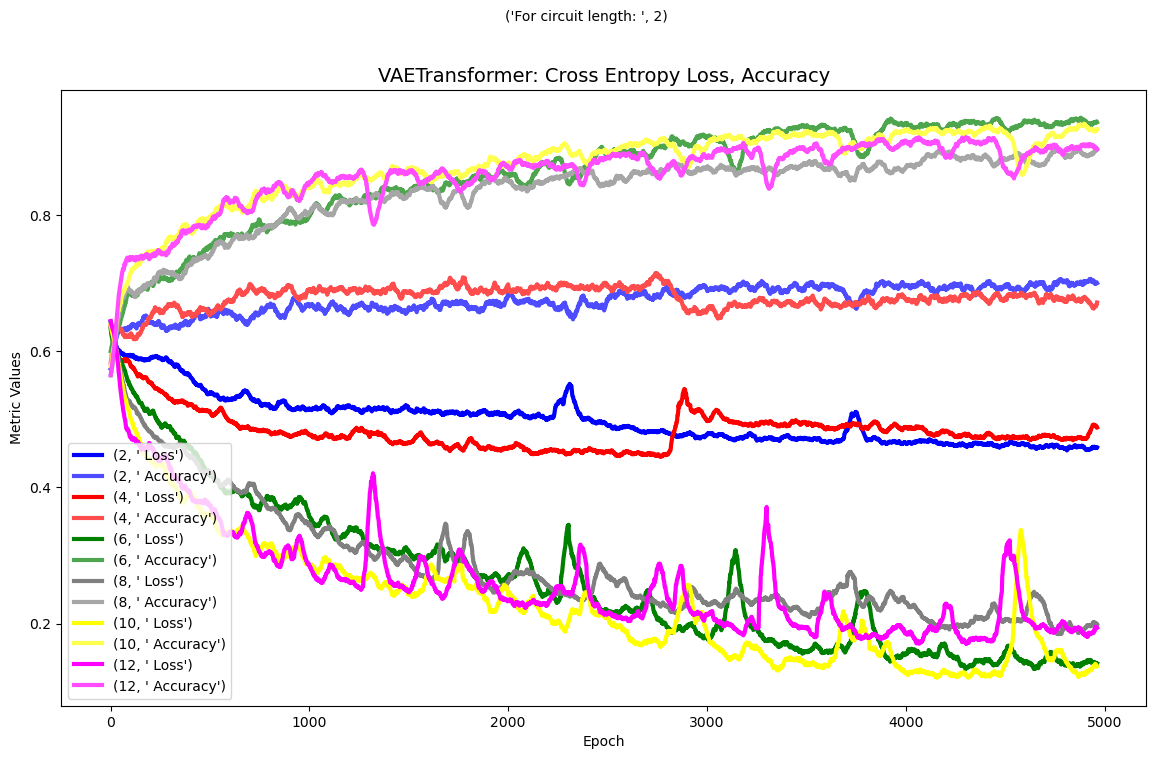

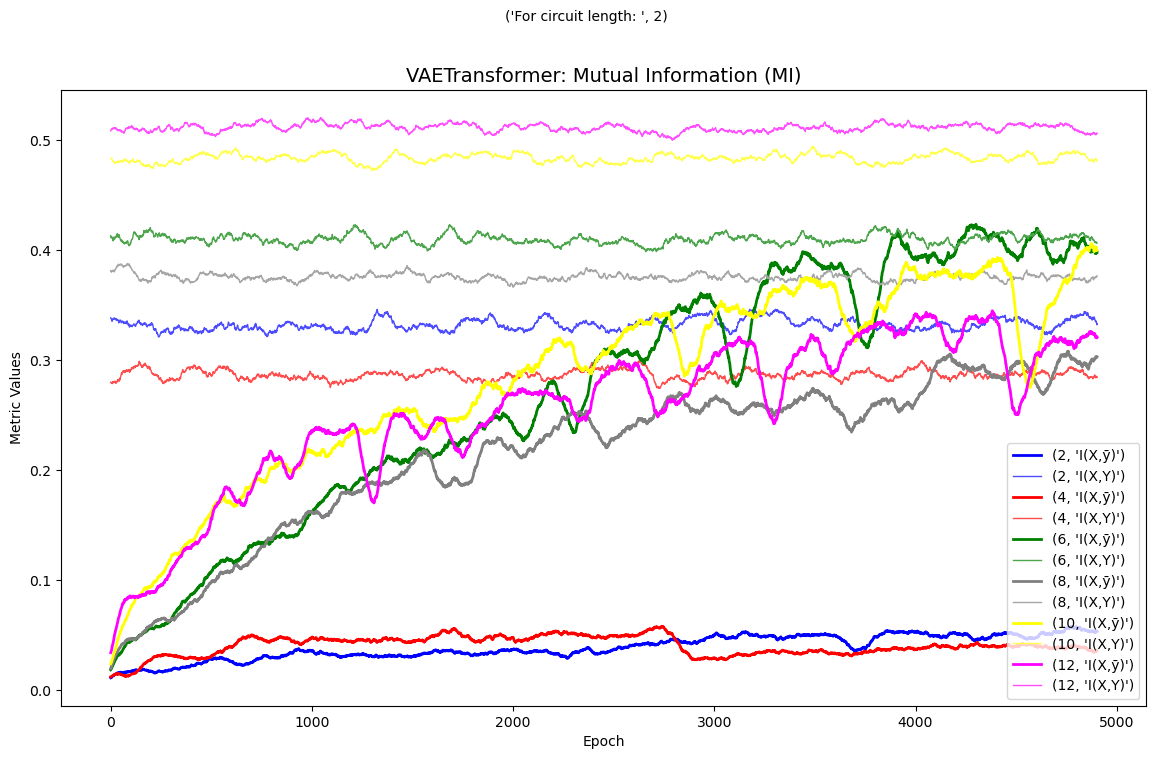

In [154]:
if __name__ == '__main__':

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('Device:', device)
    
    # Dataset Hyperparameters
    num_qbits = 12
    num_final_per_initial = 4
    inverse_density = 3
    num_ones = int(num_qbits/inverse_density)
    batch_size = 64
    circuit_length = 2
    
    # Model Hyperparameters
    latent_spaces = [2,4,6,8,10,12]
    hidden_dim = 32
    dropout = 0.1
    learning_rate = 1e-2
    num_steps = 5000
    
    dataset_hyperparams = (num_qbits, num_final_per_initial, inverse_density, num_ones, batch_size, circuit_length)    
    model_hyperparams = (hidden_dim, dropout, learning_rate, num_steps)
    
    #losses, BAccs, MIs, expected MIs
    all_loss_arrays = []
    all_acc_arrays = []
    all_mi_arrays = []
    all_expected_mi_arrays = []

    for i, (latent_space) in enumerate(latent_spaces):
        temp_loss, temp_acc, temp_mi, temp_exmi = train_VAETransformer(*dataset_hyperparams, latent_space, *model_hyperparams, device)
        all_loss_arrays.append(temp_loss)
        all_acc_arrays.append(temp_acc)
        all_mi_arrays.append(temp_mi)
        all_expected_mi_arrays.append(temp_exmi)
            

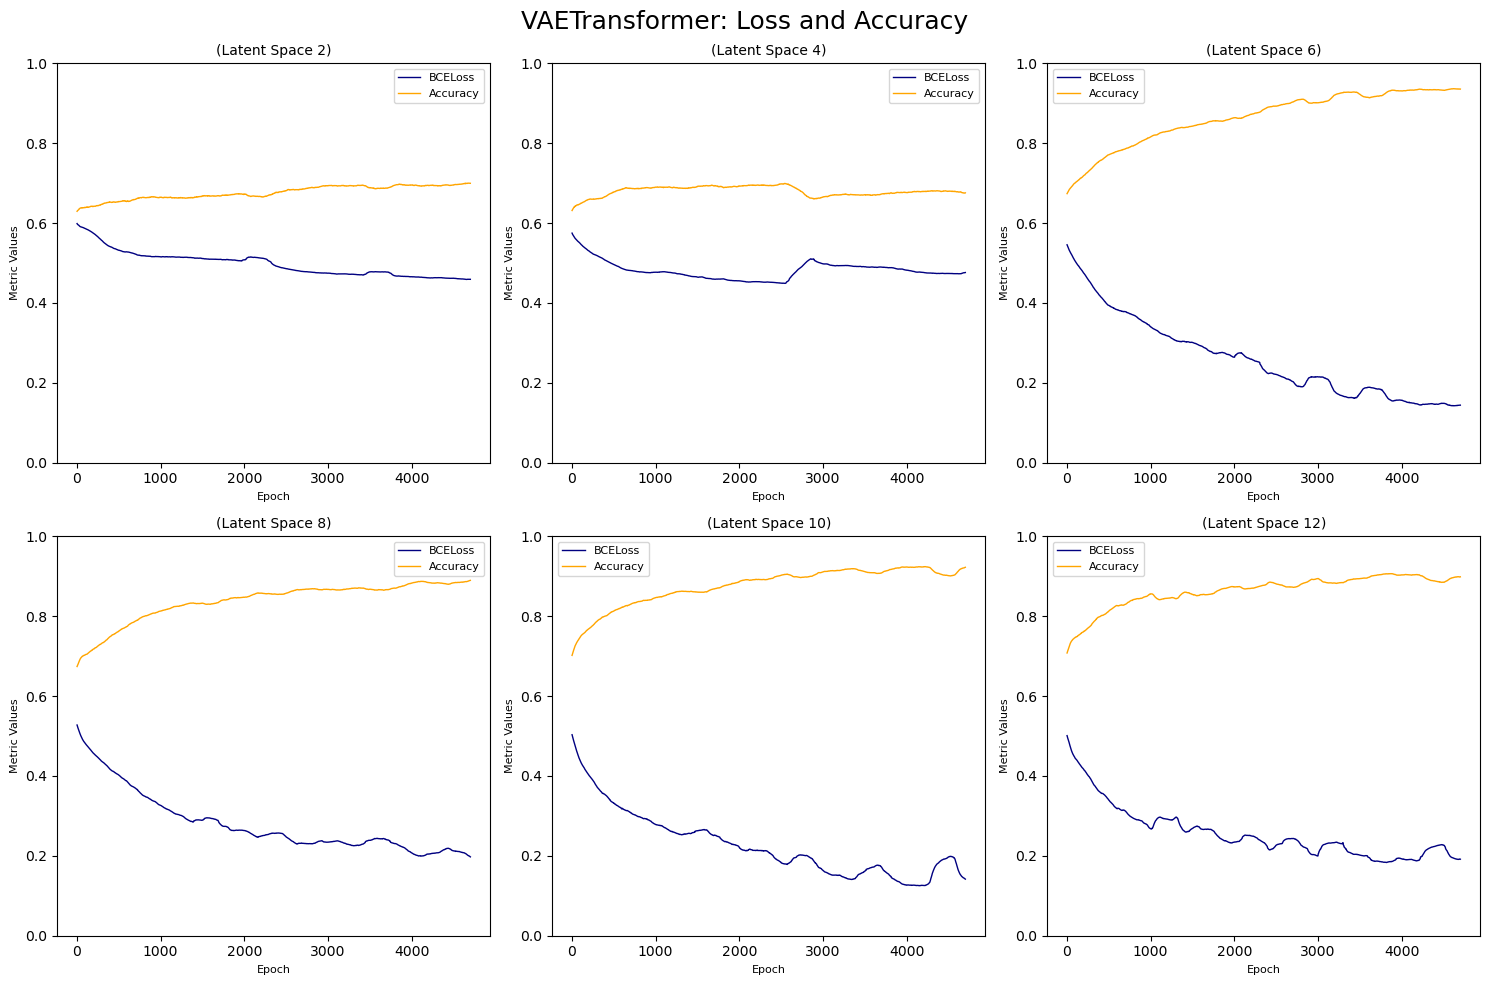

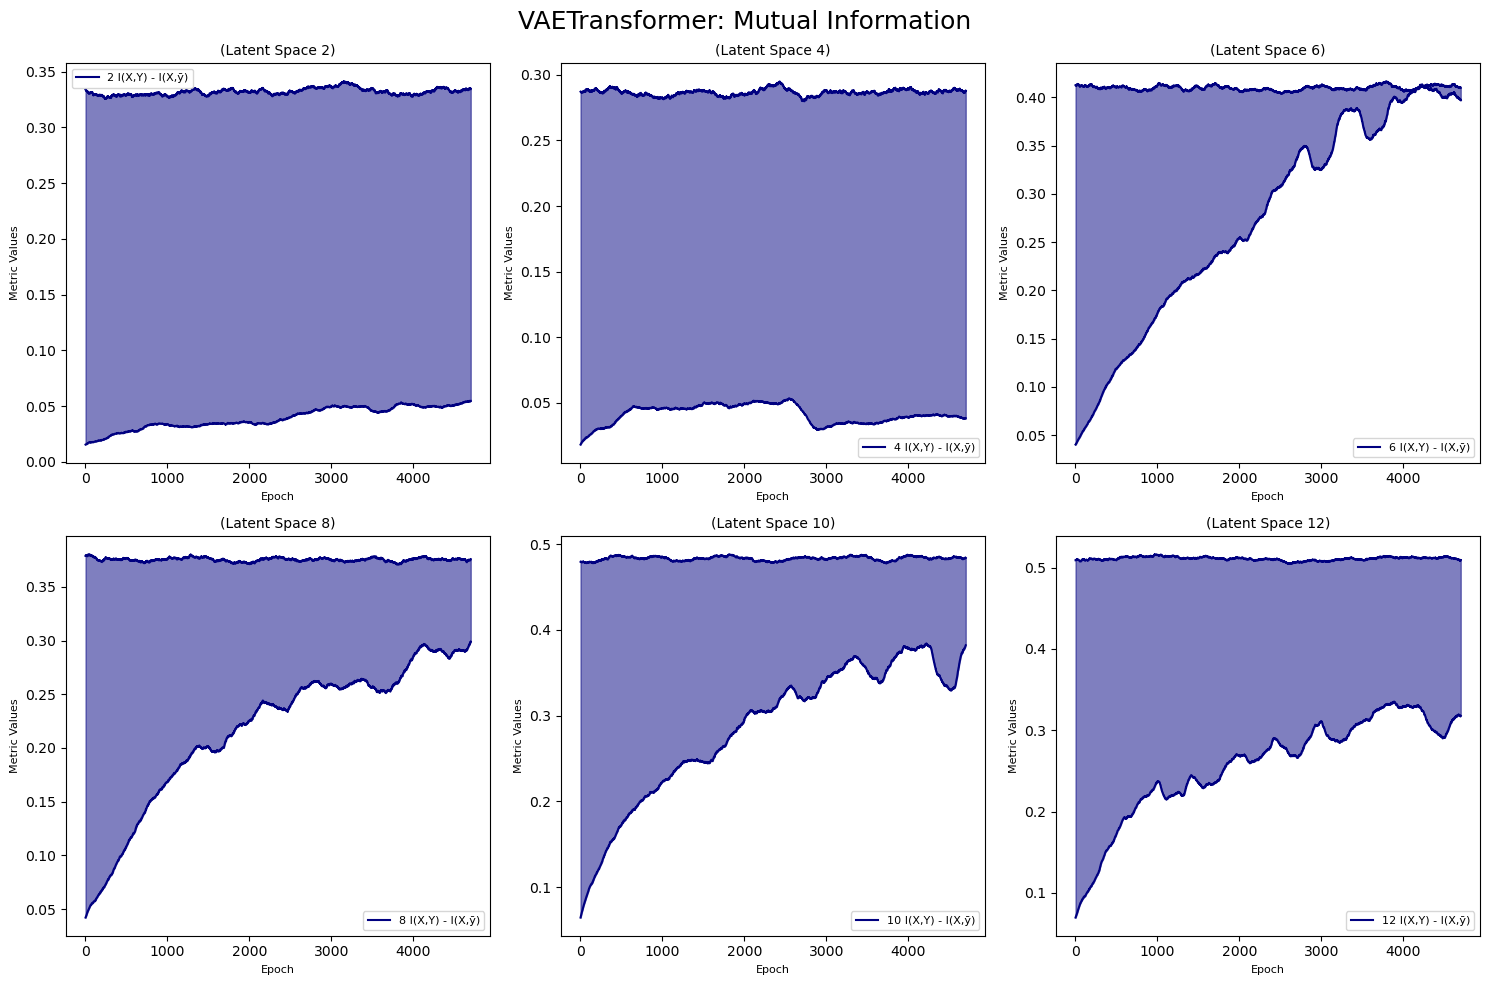

In [265]:
plot_loss_accuracy(all_loss_arrays, all_acc_arrays, circuit_length, num_qbits, latent_spaces)
plot_MI(all_mi_arrays, all_expected_mi_arrays, circuit_length, num_qbits, latent_spaces)

In [266]:
print(model_hyperparams)
print(dataset_hyperparams)
print(latent_spaces)

(32, 0.1, 0.01, 5000)
(12, 4, 3, 4, 64, 2)
[2, 4, 6, 8, 10, 12]
